<a href="https://colab.research.google.com/github/meghamohan52021/supply-chain-optimization-tool/blob/master/Supply_Chain_Optimization_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optimal solution found with total cost: 760.0
Ship 20.0 units from supply point 0 to demand point 0
Ship 30.0 units from supply point 0 to demand point 2
Ship 10.0 units from supply point 1 to demand point 0
Ship 50.0 units from supply point 1 to demand point 1
Ship 40.0 units from supply point 2 to demand point 2


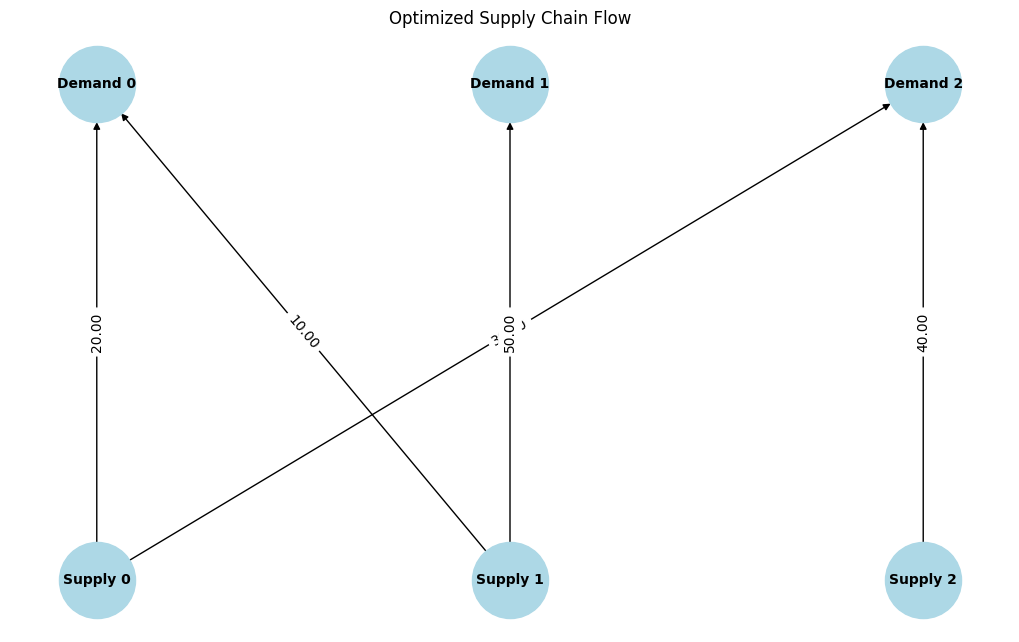

In [3]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import networkx as nx

def optimize_supply_chain(transportation_costs, supply_quantities, demand_quantities):

    num_supply_points = len(supply_quantities)
    num_demand_points = len(demand_quantities)

    #flatten cost matrix into a 1D array
    c = np.array(transportation_costs).flatten()

    #create matrix for supply constraints
    constraint_matrix = []
    for i in range(num_supply_points):
        row = [0] * (num_supply_points * num_demand_points)
        for j in range(num_demand_points):
            row[i * num_demand_points + j] = 1
        constraint_matrix.append(row)

    #create the matrix for demand constraints
    for j in range(num_demand_points):
        row = [0] * (num_supply_points * num_demand_points)
        for i in range(num_supply_points):
            row[i * num_demand_points + j] = -1
        constraint_matrix.append(row)

    #create upper bound values for the constraints
    upper_bound_values = np.concatenate([supply_quantities, -np.array(demand_quantities)])

    #bounds for decision variables
    shipping_limits = [(0, None)] * (num_supply_points * num_demand_points)

    result = linprog(c, A_ub=constraint_matrix, b_ub=upper_bound_values, bounds=shipping_limits, method='highs')

    if result.success:
        print(f"Optimal solution found with total cost: {result.fun}")
        #convert result into a matrix
        optimized_shipping = result.x.reshape((num_supply_points, num_demand_points))
        for i in range(num_supply_points):
            for j in range(num_demand_points):
                if optimized_shipping[i, j] > 0:
                    print(f"Ship {optimized_shipping[i, j]} units from supply point {i} to demand point {j}")

        #visualization
        plot_supply_chain_flow(transportation_costs, supply_quantities, demand_quantities, optimized_shipping)
    else:
        print("No optimal solution found.")

def plot_supply_chain_flow(transportation_costs, supply_quantities, demand_quantities, optimized_shipping):
    # graph
    G = nx.DiGraph()

    num_supply_points = len(supply_quantities)
    num_demand_points = len(demand_quantities)

    for i in range(num_supply_points):
        G.add_node(f'Supply {i}', supply=supply_quantities[i])


    for j in range(num_demand_points):
        G.add_node(f'Demand {j}', demand=demand_quantities[j])


    for i in range(num_supply_points):
        for j in range(num_demand_points):
            if optimized_shipping[i, j] > 0:
                G.add_edge(f'Supply {i}', f'Demand {j}', weight=optimized_shipping[i, j], cost=transportation_costs[i][j])

    #get positions for nodes
    pos = {f'Supply {i}': (i, 0) for i in range(num_supply_points)}
    pos.update({f'Demand {j}': (j, 1) for j in range(num_demand_points)})

    #network graph
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10, font_weight='bold', arrows=True)

    #to how the flow on the edges
    edge_labels = {(f'Supply {i}', f'Demand {j}'): f'{optimized_shipping[i,j]:.2f}' for i in range(num_supply_points) for j in range(num_demand_points) if optimized_shipping[i,j] > 0}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Optimized Supply Chain Flow")
    plt.show()

#Test Data
transportation_costs = [[4, 6, 8], [3, 5, 7], [9, 7, 4]]
supply_quantities = [50, 60, 40]  # Supply at each source
demand_quantities = [30, 50, 70]  # Demand at each destination

optimize_supply_chain(transportation_costs, supply_quantities, demand_quantities)
